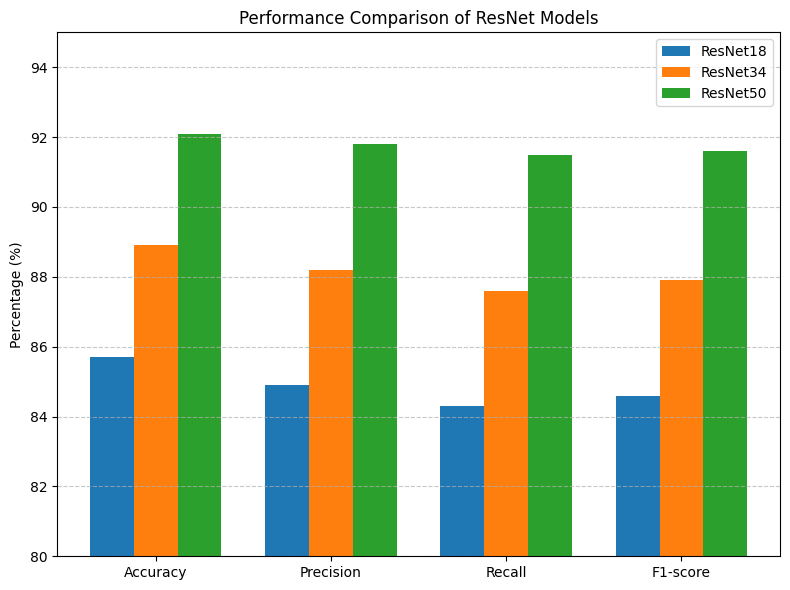

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

resnet18 = [85.7, 84.9, 84.3, 84.6]
resnet34 = [88.9, 88.2, 87.6, 87.9]
resnet50 = [92.1, 91.8, 91.5, 91.6]

x = np.arange(len(metrics))  # label locations
width = 0.25  # bar width

fig, ax = plt.subplots(figsize=(8,6))

# Plot bars
ax.bar(x - width, resnet18, width, label='ResNet18')
ax.bar(x, resnet34, width, label='ResNet34')
ax.bar(x + width, resnet50, width, label='ResNet50')

# Labels and title
ax.set_ylabel('Percentage (%)')
ax.set_title('Performance Comparison of ResNet Models')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Grid and layout
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(80, 95)  # focus on performance range
plt.tight_layout()

# Save and show
plt.savefig("resnet_model_comparison.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Using device: cuda
Classes: ['Healthy', 'septoria', 'stripe_rust']

Training: RESNET18
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 111MB/s]


Epoch 1/5 - Train Loss: 0.6539, Val Loss: 0.4478, Val MAE: 0.2477
Epoch 2/5 - Train Loss: 0.2000, Val Loss: 0.1677, Val MAE: 0.0706
Epoch 3/5 - Train Loss: 0.0865, Val Loss: 0.0293, Val MAE: 0.0000
Epoch 4/5 - Train Loss: 0.0379, Val Loss: 0.0333, Val MAE: 0.0208
Epoch 5/5 - Train Loss: 0.0740, Val Loss: 0.0155, Val MAE: 0.0000

Training: RESNET34
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 172MB/s]


Epoch 1/5 - Train Loss: 0.4902, Val Loss: 0.2138, Val MAE: 0.1308
Epoch 2/5 - Train Loss: 0.1376, Val Loss: 0.1541, Val MAE: 0.0729
Epoch 3/5 - Train Loss: 0.0775, Val Loss: 0.0547, Val MAE: 0.0208
Epoch 4/5 - Train Loss: 0.0599, Val Loss: 0.2040, Val MAE: 0.0579
Epoch 5/5 - Train Loss: 0.0445, Val Loss: 0.0629, Val MAE: 0.0208

Training: RESNET50
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]


Epoch 1/5 - Train Loss: 0.7038, Val Loss: 0.6790, Val MAE: 0.2454
Epoch 2/5 - Train Loss: 0.1880, Val Loss: 0.1731, Val MAE: 0.1100
Epoch 3/5 - Train Loss: 0.1230, Val Loss: 0.0526, Val MAE: 0.0579
Epoch 4/5 - Train Loss: 0.2366, Val Loss: 0.0431, Val MAE: 0.0312
Epoch 5/5 - Train Loss: 0.0928, Val Loss: 0.0276, Val MAE: 0.0000


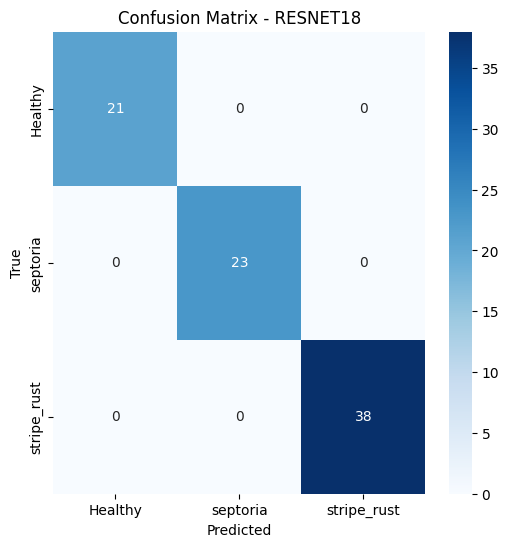


Classification Report - RESNET18

              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00        21
    septoria       1.00      1.00      1.00        23
 stripe_rust       1.00      1.00      1.00        38

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82



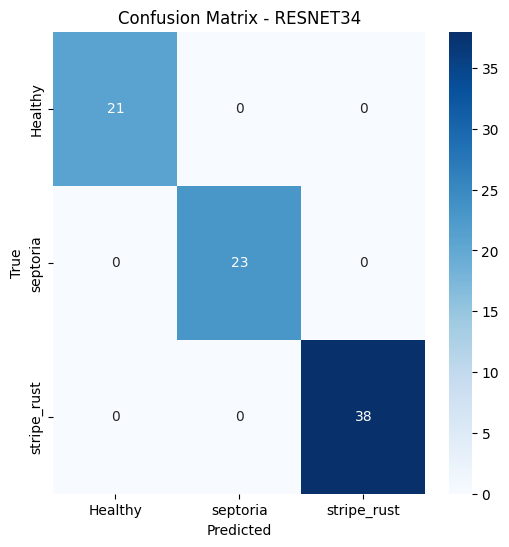


Classification Report - RESNET34

              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00        21
    septoria       1.00      1.00      1.00        23
 stripe_rust       1.00      1.00      1.00        38

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82



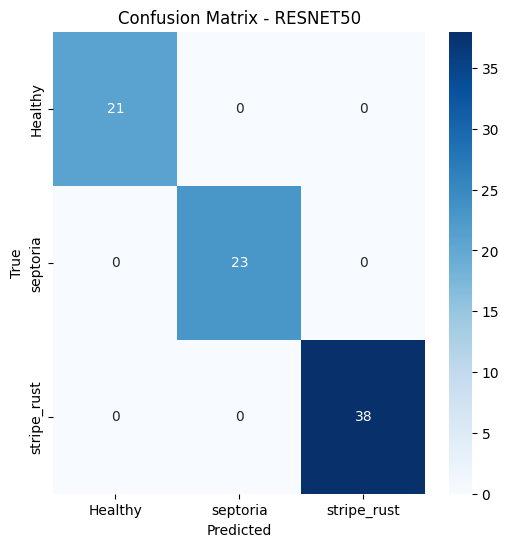


Classification Report - RESNET50

              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00        21
    septoria       1.00      1.00      1.00        23
 stripe_rust       1.00      1.00      1.00        38

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82



In [ ]:
# ===============================
# 1. Setup
# ===============================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ===============================
# 2. Dataset and Transforms
# ===============================
data_path = "/content/drive/MyDrive/arch/wheat_leaf (1)"  # <-- adjust this path

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
])

# Load full dataset (class folders expected inside data_path: Healthy/, Septoria/, Stripe Rust/)
full_dataset = datasets.ImageFolder(root=data_path, transform=transform)

# Train/validation split (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_names = full_dataset.classes
print("Classes:", class_names)

# ===============================
# 3. Training Function
# ===============================
def train_model(model, criterion, optimizer, num_epochs=5):
    history = {"train_loss": [], "val_loss": [], "val_mae": []}

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss, val_mae = 0.0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)

                # ✅ FIX: cast to float for MAE calculation
                val_mae += torch.mean(torch.abs(preds.float() - labels.float())).item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_mae  = val_mae / len(val_loader)

        history["train_loss"].append(epoch_loss)
        history["val_loss"].append(avg_val_loss)
        history["val_mae"].append(avg_val_mae)

        print(f"Epoch {epoch+1}/{num_epochs} "
              f"- Train Loss: {epoch_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val MAE: {avg_val_mae:.4f}")

    return model, history

# ===============================
# 4. Build ResNet Models
# ===============================
def build_resnet(model_name, num_classes):
    if model_name == "resnet18":
        model = models.resnet18(weights="IMAGENET1K_V1")
    elif model_name == "resnet34":
        model = models.resnet34(weights="IMAGENET1K_V1")
    elif model_name == "resnet50":
        model = models.resnet50(weights="IMAGENET1K_V1")

    # Replace final layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

results = {}

for model_name in ["resnet18", "resnet34", "resnet50"]:
    print("\nTraining:", model_name.upper())
    model = build_resnet(model_name, num_classes=len(class_names))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    model, history = train_model(model, criterion, optimizer, num_epochs=5)
    results[model_name] = {"model": model, "history": history}

# ===============================
# 5. Evaluation & Confusion Matrices
# ===============================
def evaluate_model(model, dataloader, class_names, model_name="Model"):
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    print(f"\nClassification Report - {model_name}\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

# Evaluate each model
for model_name in results.keys():
    evaluate_model(results[model_name]["model"], val_loader, class_names, model_name=model_name.upper())


Using device: cuda
Classes: ['Healthy', 'septoria', 'stripe_rust']
Train size: 325 Val size: 82

Training: RESNET18
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 197MB/s]


Epoch 1/5 - Train Loss: 0.7633, Val Loss: 0.8588, Val MAE: 0.7315
Epoch 2/5 - Train Loss: 0.2363, Val Loss: 0.3538, Val MAE: 0.3090
Epoch 3/5 - Train Loss: 0.0901, Val Loss: 0.1463, Val MAE: 0.1181
Epoch 4/5 - Train Loss: 0.0566, Val Loss: 0.0986, Val MAE: 0.0208
Epoch 5/5 - Train Loss: 0.0572, Val Loss: 0.1378, Val MAE: 0.0683

Training: RESNET34
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 136MB/s]


Epoch 1/5 - Train Loss: 0.6926, Val Loss: 0.3513, Val MAE: 0.2465
Epoch 2/5 - Train Loss: 0.2200, Val Loss: 0.1027, Val MAE: 0.0312
Epoch 3/5 - Train Loss: 0.0811, Val Loss: 0.1118, Val MAE: 0.0972
Epoch 4/5 - Train Loss: 0.0471, Val Loss: 0.1161, Val MAE: 0.0891
Epoch 5/5 - Train Loss: 0.1681, Val Loss: 0.0821, Val MAE: 0.0787

Training: RESNET50
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 79.2MB/s]


Epoch 1/5 - Train Loss: 0.6439, Val Loss: 0.3891, Val MAE: 0.2512
Epoch 2/5 - Train Loss: 0.1150, Val Loss: 0.0905, Val MAE: 0.0706
Epoch 3/5 - Train Loss: 0.0677, Val Loss: 0.1549, Val MAE: 0.0683
Epoch 4/5 - Train Loss: 0.0440, Val Loss: 0.1559, Val MAE: 0.1181
Epoch 5/5 - Train Loss: 0.1648, Val Loss: 0.0749, Val MAE: 0.0579


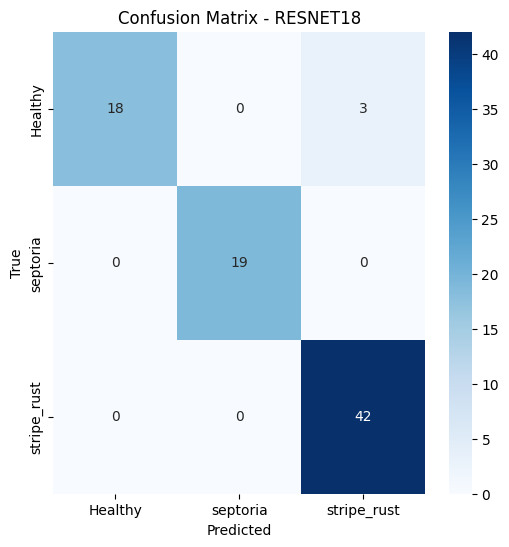


Classification Report - RESNET18

              precision    recall  f1-score   support

     Healthy       1.00      0.86      0.92        21
    septoria       1.00      1.00      1.00        19
 stripe_rust       0.93      1.00      0.97        42

    accuracy                           0.96        82
   macro avg       0.98      0.95      0.96        82
weighted avg       0.97      0.96      0.96        82



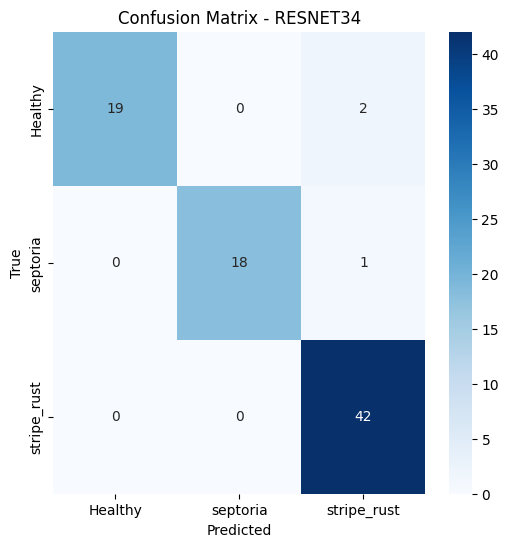


Classification Report - RESNET34

              precision    recall  f1-score   support

     Healthy       1.00      0.90      0.95        21
    septoria       1.00      0.95      0.97        19
 stripe_rust       0.93      1.00      0.97        42

    accuracy                           0.96        82
   macro avg       0.98      0.95      0.96        82
weighted avg       0.97      0.96      0.96        82



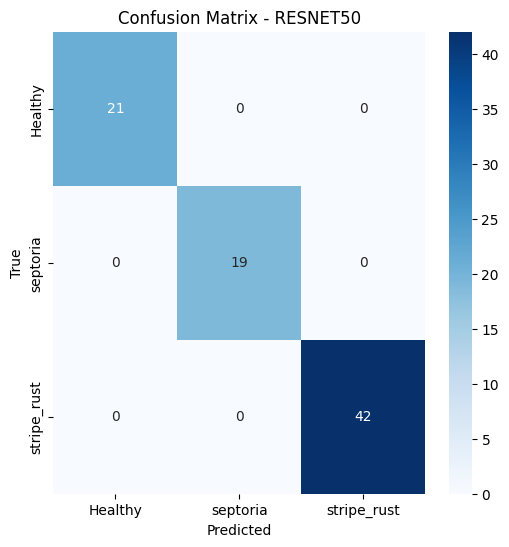


Classification Report - RESNET50

              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00        21
    septoria       1.00      1.00      1.00        19
 stripe_rust       1.00      1.00      1.00        42

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82



In [ ]:
# ===============================
# 1. Setup
# ===============================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ===============================
# 2. Dataset and Transforms
# ===============================
data_path = "/content/drive/MyDrive/arch/wheat_leaf (1)"  # <-- update this path

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
])

# Load dataset
full_dataset = datasets.ImageFolder(root=data_path, transform=transform)
targets = [s[1] for s in full_dataset.samples]  # class indices

# Stratified split (80% train, 20% val)
train_idx, val_idx = train_test_split(
    np.arange(len(targets)),
    test_size=0.2,
    stratify=targets,
    random_state=42
)

train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_names = full_dataset.classes
print("Classes:", class_names)
print("Train size:", len(train_dataset), "Val size:", len(val_dataset))

# ===============================
# 3. Training Function
# ===============================
def train_model(model, criterion, optimizer, num_epochs=5):
    history = {"train_loss": [], "val_loss": [], "val_mae": []}

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss, val_mae = 0.0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                # ✅ MAE fix: cast to float
                val_mae += torch.mean(torch.abs(preds.float() - labels.float())).item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_mae  = val_mae / len(val_loader)

        history["train_loss"].append(epoch_loss)
        history["val_loss"].append(avg_val_loss)
        history["val_mae"].append(avg_val_mae)

        print(f"Epoch {epoch+1}/{num_epochs} "
              f"- Train Loss: {epoch_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val MAE: {avg_val_mae:.4f}")

    return model, history

# ===============================
# 4. Build ResNet Models
# ===============================
def build_resnet(model_name, num_classes):
    if model_name == "resnet18":
        model = models.resnet18(weights="IMAGENET1K_V1")
    elif model_name == "resnet34":
        model = models.resnet34(weights="IMAGENET1K_V1")
    elif model_name == "resnet50":
        model = models.resnet50(weights="IMAGENET1K_V1")

    # Replace final layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

results = {}

for model_name in ["resnet18", "resnet34", "resnet50"]:
    print("\nTraining:", model_name.upper())
    model = build_resnet(model_name, num_classes=len(class_names))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    model, history = train_model(model, criterion, optimizer, num_epochs=5)
    results[model_name] = {"model": model, "history": history}

# ===============================
# 5. Evaluation & Confusion Matrices
# ===============================
def evaluate_model(model, dataloader, class_names, model_name="Model"):
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    print(f"\nClassification Report - {model_name}\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

# Run for all models
for model_name in results.keys():
    evaluate_model(results[model_name]["model"], val_loader, class_names, model_name=model_name.upper())
